In [ ]:
!git clone 'https://github.com/shaheer1995/A2S2K-ResNet'

fatal: destination path 'A2S2K-ResNet' already exists and is not an empty directory.


In [ ]:
%cd /content/A2S2K-ResNet/SSRN/

/content/A2S2K-ResNet/SSRN


In [ ]:
!pip install torch-optimizer==0.0.1a12
!pip install spectral==0.20

In [ ]:
import argparse
import collections
import math
import time

import numpy as np
import scipy.io as sio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn import metrics, preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

import geniter
import record
import torch_optimizer as optim2
import Utils
from torchsummary import summary

In [ ]:
# # Setting Params
PARAM_DATASET = 'UP'  # UP,IN,SV, KSC
PARAM_EPOCH = 50
PARAM_ITER = 1
PATCH_SIZE = 4
PARAM_VAL = 0.9
PARAM_OPTIM = 'adam'

In [ ]:
!wget http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat

--2021-02-13 05:30:58--  http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5953527 (5.7M)
Saving to: ‘Indian_pines_corrected.mat.2’

Indian_pines_correc 100%[===================>]   5.68M   584KB/s    in 11s     

2021-02-13 05:31:10 (515 KB/s) - ‘Indian_pines_corrected.mat.2’ saved [5953527/5953527]



In [ ]:
#Download Datasets
%cd /content/
%mkdir datasets
%cd /content/datasets

!wget http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
!wget http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
!wget http://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat
!wget http://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat
!wget http://www.ehu.es/ccwintco/uploads/2/26/KSC.mat
!wget http://www.ehu.es/ccwintco/uploads/a/a6/KSC_gt.mat
!wget https://github.com/gokriznastic/HybridSN/raw/master/data/Salinas_corrected.mat
!wget https://github.com/gokriznastic/HybridSN/raw/master/data/Salinas_gt.mat               

/content
mkdir: cannot create directory ‘datasets’: File exists
/content/datasets
--2021-02-13 05:31:10--  http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5953527 (5.7M)
Saving to: ‘Indian_pines_corrected.mat.2’

Indian_pines_correc 100%[===================>]   5.68M   558KB/s    in 12s     

2021-02-13 05:31:22 (486 KB/s) - ‘Indian_pines_corrected.mat.2’ saved [5953527/5953527]

--2021-02-13 05:31:22--  http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1125 (1.1K)
Saving to: ‘Indian_pines_gt.mat.2’

Indian_pines_gt.mat 100%[===================>]   1.10K  --.-KB/s    i

In [ ]:
# # Data Loading

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# for Monte Carlo runs
seeds = [1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341]
ensemble = 1

global Dataset  # UP,IN,SV, KSC
dataset = PARAM_DATASET  #input('Please input the name of Dataset(IN, UP, SV, KSC):')
Dataset = dataset.upper()


def load_dataset(Dataset, split=0.9):
    data_path = '/content/datasets/'
    if Dataset == 'IN':
        mat_data = sio.loadmat(data_path + 'Indian_pines_corrected.mat')
        mat_gt = sio.loadmat(data_path + 'Indian_pines_gt.mat')
        data_hsi = mat_data['indian_pines_corrected']
        gt_hsi = mat_gt['indian_pines_gt']
        K = data_hsi.shape[2]
        TOTAL_SIZE = 10249
        VALIDATION_SPLIT = split
        TRAIN_SIZE = math.ceil(TOTAL_SIZE * VALIDATION_SPLIT)

    if Dataset == 'UP':
        uPavia = sio.loadmat(data_path + 'PaviaU.mat')
        gt_uPavia = sio.loadmat(data_path + 'PaviaU_gt.mat')
        data_hsi = uPavia['paviaU']
        gt_hsi = gt_uPavia['paviaU_gt']
        K = data_hsi.shape[2]
        TOTAL_SIZE = 42776
        VALIDATION_SPLIT = split
        TRAIN_SIZE = math.ceil(TOTAL_SIZE * VALIDATION_SPLIT)

    if Dataset == 'SV':
        SV = sio.loadmat(data_path + 'Salinas_corrected.mat')
        gt_SV = sio.loadmat(data_path + 'Salinas_gt.mat')
        data_hsi = SV['salinas_corrected']
        gt_hsi = gt_SV['salinas_gt']
        K = data_hsi.shape[2]
        TOTAL_SIZE = 54129
        VALIDATION_SPLIT = split
        TRAIN_SIZE = math.ceil(TOTAL_SIZE * VALIDATION_SPLIT)

    if Dataset == 'KSC':
        SV = sio.loadmat(data_path + 'KSC.mat')
        gt_SV = sio.loadmat(data_path + 'KSC_gt.mat')
        data_hsi = SV['KSC']
        gt_hsi = gt_SV['KSC_gt']
        K = data_hsi.shape[2]
        TOTAL_SIZE = 5211
        VALIDATION_SPLIT = split
        TRAIN_SIZE = math.ceil(TOTAL_SIZE * VALIDATION_SPLIT)

    shapeor = data_hsi.shape
    data_hsi = data_hsi.reshape(-1, data_hsi.shape[-1])
    data_hsi = PCA(n_components=K).fit_transform(data_hsi)
    shapeor = np.array(shapeor)
    shapeor[-1] = K
    data_hsi = data_hsi.reshape(shapeor)

    return data_hsi, gt_hsi, TOTAL_SIZE, TRAIN_SIZE, VALIDATION_SPLIT

In [ ]:
# # Pytorch Data Loader Creation

data_hsi, gt_hsi, TOTAL_SIZE, TRAIN_SIZE, VALIDATION_SPLIT = load_dataset(Dataset, PARAM_VAL)
print(data_hsi.shape)
image_x, image_y, BAND = data_hsi.shape
data = data_hsi.reshape(
    np.prod(data_hsi.shape[:2]), np.prod(data_hsi.shape[2:]))
gt = gt_hsi.reshape(np.prod(gt_hsi.shape[:2]), )
CLASSES_NUM = max(gt)
print('The class numbers of the HSI data is:', CLASSES_NUM)

print('-----Importing Setting Parameters-----')
ITER = PARAM_ITER
PATCH_LENGTH = PATCH_SIZE
lr, num_epochs, batch_size = 0.001, 200, 32
loss = torch.nn.CrossEntropyLoss()

img_rows = 2 * PATCH_LENGTH + 1
img_cols = 2 * PATCH_LENGTH + 1
img_channels = data_hsi.shape[2]
INPUT_DIMENSION = data_hsi.shape[2]
ALL_SIZE = data_hsi.shape[0] * data_hsi.shape[1]
VAL_SIZE = int(TRAIN_SIZE)
TEST_SIZE = TOTAL_SIZE - TRAIN_SIZE

KAPPA = []
OA = []
AA = []
TRAINING_TIME = []
TESTING_TIME = []
ELEMENT_ACC = np.zeros((ITER, CLASSES_NUM))

data = preprocessing.scale(data)
data_ = data.reshape(data_hsi.shape[0], data_hsi.shape[1], data_hsi.shape[2])
whole_data = data_
padded_data = np.lib.pad(
    whole_data, ((PATCH_LENGTH, PATCH_LENGTH), (PATCH_LENGTH, PATCH_LENGTH),
                 (0, 0)),
    'constant',
    constant_values=0)


(610, 340, 103)
The class numbers of the HSI data is: 9
-----Importing Setting Parameters-----


In [ ]:
# # Model


class Residual(nn.Module):  # pytorch
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 padding,
                 use_1x1conv=False,
                 stride=1):
        super(Residual, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv3d(
                in_channels,
                out_channels,
                kernel_size=kernel_size,
                padding=padding,
                stride=stride), nn.ReLU())
        self.conv2 = nn.Conv3d(
            out_channels,
            out_channels,
            kernel_size=kernel_size,
            padding=padding,
            stride=stride)
        if use_1x1conv:
            self.conv3 = nn.Conv3d(
                in_channels, out_channels, kernel_size=1, stride=stride)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.bn2 = nn.BatchNorm3d(out_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        return F.relu(Y + X)


class SSRN_network(nn.Module):
    def __init__(self, band, classes):
        super(SSRN_network, self).__init__()
        self.name = 'SSRN'
        self.conv1 = nn.Conv3d(
            in_channels=1,
            out_channels=24,
            kernel_size=(1, 1, 7),
            stride=(1, 1, 2))
        self.batch_norm1 = nn.Sequential(
            nn.BatchNorm3d(24, eps=0.001, momentum=0.1, affine=True),  # 0.1
            nn.ReLU(inplace=True))

        self.res_net1 = Residual(24, 24, (1, 1, 7), (0, 0, 3))
        self.res_net2 = Residual(24, 24, (1, 1, 7), (0, 0, 3))
        self.res_net3 = Residual(24, 24, (3, 3, 1), (1, 1, 0))
        self.res_net4 = Residual(24, 24, (3, 3, 1), (1, 1, 0))

        kernel_3d = math.ceil((band - 6) / 2)

        self.conv2 = nn.Conv3d(
            in_channels=24,
            out_channels=128,
            padding=(0, 0, 0),
            kernel_size=(1, 1, kernel_3d),
            stride=(1, 1, 1))
        self.batch_norm2 = nn.Sequential(
            nn.BatchNorm3d(128, eps=0.001, momentum=0.1, affine=True),  # 0.1
            nn.ReLU(inplace=True))
        self.conv3 = nn.Conv3d(
            in_channels=1,
            out_channels=24,
            padding=(0, 0, 0),
            kernel_size=(3, 3, 128),
            stride=(1, 1, 1))
        self.batch_norm3 = nn.Sequential(
            nn.BatchNorm3d(24, eps=0.001, momentum=0.1, affine=True),  # 0.1
            nn.ReLU(inplace=True))

        self.avg_pooling = nn.AvgPool3d(kernel_size=(5, 5, 1))
        self.full_connection = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(24, classes)  # ,
            # nn.Softmax()
        )

    def forward(self, X):
        x1 = self.batch_norm1(self.conv1(X))
        # print('x1', x1.shape)

        x2 = self.res_net1(x1)
        x2 = self.res_net2(x2)
        x2 = self.batch_norm2(self.conv2(x2))
        x2 = x2.permute(0, 4, 2, 3, 1)
        x2 = self.batch_norm3(self.conv3(x2))

        x3 = self.res_net3(x2)
        x3 = self.res_net4(x3)
        x4 = self.avg_pooling(x3)
        x4 = x4.view(x4.size(0), -1)
        return self.full_connection(x4)

In [ ]:
model = SSRN_network(BAND, CLASSES_NUM).cuda()

In [ ]:
print(model)

SSRN_network(
  (conv1): Conv3d(1, 24, kernel_size=(1, 1, 7), stride=(1, 1, 2))
  (batch_norm1): Sequential(
    (0): BatchNorm3d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU(inplace=True)
  )
  (res_net1): Residual(
    (conv1): Sequential(
      (0): Conv3d(24, 24, kernel_size=(1, 1, 7), stride=(1, 1, 1), padding=(0, 0, 3))
      (1): ReLU()
    )
    (conv2): Conv3d(24, 24, kernel_size=(1, 1, 7), stride=(1, 1, 1), padding=(0, 0, 3))
    (bn1): BatchNorm3d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm3d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_net2): Residual(
    (conv1): Sequential(
      (0): Conv3d(24, 24, kernel_size=(1, 1, 7), stride=(1, 1, 1), padding=(0, 0, 3))
      (1): ReLU()
    )
    (conv2): Conv3d(24, 24, kernel_size=(1, 1, 7), stride=(1, 1, 1), padding=(0, 0, 3))
    (bn1): BatchNorm3d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [ ]:
def train(net,
          train_iter,
          valida_iter,
          loss,
          optimizer,
          device,
          epochs,
          early_stopping=True,
          early_num=20):
    loss_list = [100]
    early_epoch = 0

    net = net.to(device)
    print("training on ", device)
    start = time.time()
    train_loss_list = []
    valida_loss_list = []
    train_acc_list = []
    valida_acc_list = []
    for epoch in range(epochs):
        train_acc_sum, n = 0.0, 0
        time_epoch = time.time()
        lr_adjust = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, 15, eta_min=0.0, last_epoch=-1)
        for X, y in train_iter:

            batch_count, train_l_sum = 0, 0
            #X = X.permute(0, 3, 1, 2)
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            # print('y_hat', y_hat)
            # print('y', y)
            l = loss(y_hat, y.long())

            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
        lr_adjust.step()
        valida_acc, valida_loss = record.evaluate_accuracy(
            valida_iter, net, loss, device)
        loss_list.append(valida_loss)

        train_loss_list.append(train_l_sum)  # / batch_count)
        train_acc_list.append(train_acc_sum / n)
        valida_loss_list.append(valida_loss)
        valida_acc_list.append(valida_acc)

        print(
            'epoch %d, train loss %.6f, train acc %.3f, valida loss %.6f, valida acc %.3f, time %.1f sec'
            % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n,
               valida_loss, valida_acc, time.time() - time_epoch))

        PATH = "./net_DBA.pt"
        # if loss_list[-1] <= 0.01 and valida_acc >= 0.95:
        #     torch.save(net.state_dict(), PATH)
        #     break

        if early_stopping and loss_list[-2] < loss_list[-1]:
            if early_epoch == 0:  # and valida_acc > 0.9:
                torch.save(net.state_dict(), PATH)
            early_epoch += 1
            loss_list[-1] = loss_list[-2]
            if early_epoch == early_num:
                net.load_state_dict(torch.load(PATH))
                break
        else:
            early_epoch = 0

    print('epoch %d, loss %.4f, train acc %.3f, time %.1f sec'
          % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n,
             time.time() - start))

In [ ]:
def sampling(proportion, ground_truth):
    train = {}
    test = {}
    labels_loc = {}
    m = max(ground_truth)
    for i in range(m):
        indexes = [
            j for j, x in enumerate(ground_truth.ravel().tolist())
            if x == i + 1
        ]
        np.random.shuffle(indexes)
        labels_loc[i] = indexes
        if proportion != 1:
            nb_val = max(int((1 - proportion) * len(indexes)), 3)
        else:
            nb_val = 0
        train[i] = indexes[:nb_val]
        test[i] = indexes[nb_val:]
    train_indexes = []
    test_indexes = []
    for i in range(m):
        train_indexes += train[i]
        test_indexes += test[i]
    np.random.shuffle(train_indexes)
    np.random.shuffle(test_indexes)
    return train_indexes, test_indexes

In [ ]:
def select(groundTruth):  #divide dataset into train and test datasets
    labels_loc = {}
    train = {}
    test = {}
    m = max(groundTruth)
    #amount = [3, 41, 29, 7, 14, 20, 2, 15, 3, 36, 64, 22, 4, 28, 10, 2]
    #amount = [43, 1387, 801, 230, 469, 710, 26, 463, 17, 936, 2391, 571, 201, 1237, 376, 91]
    if Dataset == 'IN':
        amount = [
            35, 1011, 581, 167, 344, 515, 19, 327, 12, 683, 1700, 418, 138,
            876, 274, 69
        ]  #IP 20%
    #amount = [6, 144, 84, 24, 50, 75, 3, 49, 2, 97, 247, 62, 22, 130, 38, 10]   #IP 20%
    if Dataset == 'UP':
        amount = [5297, 14974, 1648, 2424, 1076, 4026, 1046, 2950, 755]  #UP
    if Dataset == 'KSC':
        amount = [
            530, 165, 176, 170, 110, 161, 80, 299, 377, 283, 296, 341, 654
        ]  #KSC
    for i in range(m):
        indices = [
            j for j, x in enumerate(groundTruth.ravel().tolist()) if x == i + 1
        ]
        np.random.shuffle(indices)
        labels_loc[i] = indices
        nb_val = int(amount[i])
        train[i] = indices[:-nb_val]
        test[i] = indices[-nb_val:]
#    whole_indices = []
    train_indices = []
    test_indices = []
    for i in range(m):
        #        whole_indices += labels_loc[i]
        train_indices += train[i]
        test_indices += test[i]
    np.random.shuffle(train_indices)
    np.random.shuffle(test_indices)
    return train_indices, test_indices

In [ ]:
%cd /content/
%mkdir models
%mkdir report
%mkdir classification_maps

/content
mkdir: cannot create directory ‘models’: File exists
mkdir: cannot create directory ‘report’: File exists
mkdir: cannot create directory ‘classification_maps’: File exists


In [ ]:
# # Training

for index_iter in range(ITER):
    print('iter:', index_iter)
    # define the model
    net = SSRN_network(BAND, CLASSES_NUM)

    if PARAM_OPTIM == 'diffgrad':
        optimizer = optim2.DiffGrad(
            net.parameters(),
            lr=lr,
            betas=(0.9, 0.999),
            eps=1e-8,
            weight_decay=0)  # weight_decay=0.0001)
    if PARAM_OPTIM == 'adam':
        optimizer = optim.Adam(
            net.parameters(),
            lr=1e-3,
            betas=(0.9, 0.999),
            eps=1e-8,
            weight_decay=0)
    time_1 = int(time.time())
    np.random.seed(seeds[index_iter])
    # train_indices, test_indices = select(gt)
    train_indices, test_indices = sampling(VALIDATION_SPLIT, gt)
    _, total_indices = sampling(1, gt)

    TRAIN_SIZE = len(train_indices)
    print('Train size: ', TRAIN_SIZE)
    TEST_SIZE = TOTAL_SIZE - TRAIN_SIZE
    print('Test size: ', TEST_SIZE)
    VAL_SIZE = int(TRAIN_SIZE)
    print('Validation size: ', VAL_SIZE)

    print('-----Selecting Small Pieces from the Original Cube Data-----')
    train_iter, valida_iter, test_iter, all_iter = geniter.generate_iter(
        TRAIN_SIZE, train_indices, TEST_SIZE, test_indices, TOTAL_SIZE,
        total_indices, VAL_SIZE, whole_data, PATCH_LENGTH, padded_data,
        INPUT_DIMENSION, 16, gt)  #batchsize in 1

    tic1 = time.time()
    train(
        net,
        train_iter,
        valida_iter,
        loss,
        optimizer,
        device,
        epochs=PARAM_EPOCH)
    toc1 = time.time()

    pred_test = []
    tic2 = time.time()
    with torch.no_grad():
        for X, y in test_iter:
            X = X.to(device)
            net.eval()
            y_hat = net(X)
            pred_test.extend(np.array(net(X).cpu().argmax(axis=1)))
    toc2 = time.time()
    collections.Counter(pred_test)
    gt_test = gt[test_indices] - 1

    overall_acc = metrics.accuracy_score(pred_test, gt_test[:-VAL_SIZE])
    confusion_matrix = metrics.confusion_matrix(pred_test, gt_test[:-VAL_SIZE])
    each_acc, average_acc = record.aa_and_each_accuracy(confusion_matrix)
    kappa = metrics.cohen_kappa_score(pred_test, gt_test[:-VAL_SIZE])

    torch.save(net.state_dict(),
               "/content/models/" + 'SSRN' + str(round(overall_acc, 3)) + '.pt')
    KAPPA.append(kappa)
    OA.append(overall_acc)
    AA.append(average_acc)
    TRAINING_TIME.append(toc1 - tic1)
    TESTING_TIME.append(toc2 - tic2)
    ELEMENT_ACC[index_iter, :] = each_acc


iter: 0
Train size:  4272
Test size:  38504
Validation size:  4272
-----Selecting Small Pieces from the Original Cube Data-----
(4272, 9, 9, 103)
training on  cuda
epoch 1, train loss 0.616170, train acc 0.710, valida loss 1.146378, valida acc 0.878, time 9.9 sec
epoch 2, train loss 0.356449, train acc 0.875, valida loss 0.256747, valida acc 0.919, time 12.7 sec
epoch 3, train loss 0.401426, train acc 0.918, valida loss 0.046967, valida acc 0.980, time 13.4 sec
epoch 4, train loss 0.271546, train acc 0.939, valida loss 0.002344, valida acc 0.981, time 13.5 sec
epoch 5, train loss 0.056420, train acc 0.941, valida loss 0.008306, valida acc 0.982, time 13.5 sec
epoch 6, train loss 0.072969, train acc 0.950, valida loss 0.000603, valida acc 0.997, time 13.5 sec
epoch 7, train loss 0.290035, train acc 0.959, valida loss 0.031783, valida acc 0.982, time 13.6 sec
epoch 8, train loss 0.156038, train acc 0.968, valida loss 0.028912, valida acc 0.998, time 13.6 sec
epoch 9, train loss 0.141695,

-------- Training Finished-----------
------Get classification maps successful-------


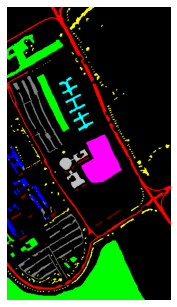

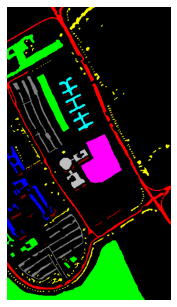

In [ ]:
# # Map, Records
print("--------" + " Training Finished-----------")
record.record_output(
    OA, AA, KAPPA, ELEMENT_ACC, TRAINING_TIME, TESTING_TIME,
    '/content/report/' + 'SSRNpatch:' + str(img_rows) + '_' + Dataset + 'split' +
    str(VALIDATION_SPLIT) + 'lr' + str(lr) + PARAM_OPTIM + '.txt')

Utils.generate_png(
    all_iter, net, gt_hsi, Dataset, device, total_indices,
    '/content/classification_maps/' + 'SSRNpatch:' + str(img_rows) + '_' + Dataset +
    'split' + str(VALIDATION_SPLIT) + 'lr' + str(lr) + PARAM_OPTIM)